# PZT Induced NDT of PE Pipes

# Data Processing of Signal Responses

This program reads data from a spreadsheet with time-domain signal responses. Data is processed, organized, and presented in the form of a pandas dataframe. All data is saved as internal structures readable in Python.

## User Inputs

All of the data is stored in an excel file in which waveguide material properties, crack geometry, FEM mesh, transducer specifications, and other such parameters are identified for each signal. The signals in this file have a sampling frequency of 100 MSa/s and duration of 5 $\mu$s. Specify this excel file under filename.

In [754]:
# Stored Data
filename = 'G:/My Drive/USGW Research/Programming/Git Cloud/USGW-in-PE-Pipes/Sensed Signals.xlsx'

# Parameters
Pipe     = 'Abaqus Model'

# Material Properties
Elasticity  = 'Elastic'
Modulus     = 1.1      # GPa
Poissons    = 0.45     # microstrains/microstrains
Density     = 1125      # kg/m^3

# Crack Geometry
Orientation   = 90;       # degrees
Location      = 100;     # mm
Depth         = 5;      # mm
Length        = 2*Depth; # mm
Width         = 2;       # mm
Circumference = 'Outside'
Order         = 1;

# Signal
Amplitude   = 0.1;       # N
Frequency   = 50000;     # Hz
Sampling    = 10000000;  # Sa/s
Cycles      = 5;

# Mesh
meshmax     = 1;            # mm
# meshmin     = 0.5;          # mm
timestep    = 1/Sampling;   # s

# Transducers
StrainCoefficient = 'U3'
PZTType           = 'Point'
Arrays            = ['R'];
Axes              = [3,4,5,6,7];

# All variables are frozen except one
variables = ['Length (mm)','Depth (mm)','Circumference']

# Artificially generated white noise
SNR = 70;

# Storage of Analysis Results
parent    = 'G:/My Drive/USGW Research/Programming/Git Cloud/USGW-in-PE-Pipes'
directory = 'Length Damaged States Perpendicular Crack'

## Preprocessing Code

### Importing Modules

In [755]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
from PIL import Image
import scipy as sp
from scipy.fft import fft, ifft
from scipy import signal
import scipy.fftpack
import math
import itertools
from itertools import product

### Functions

Calculate the root-mean squared of a signal

In [756]:
def rms(x):
    x = x[~np.isnan(x)]
    rms = np.sqrt(np.mean(x**2))
    return rms

Obtain the frequency domains of all the signals in the dataframe in the form of the Single-Sided Amplitude Spectrum:

In [757]:
def ssas (Fs, time_domain):
    (L,n)    = np.shape(time_domain);               # Size of the time domain database (number of signasl x number of samples)
    T        = 1/Fs;                                # Sampling period
    duration = time_domain.columns[-1] - time_domain.columns[0]
    t        = np.arange(0,duration + T, T);        # Zeroed time axis in seconds
    
    # Power Spectrum
    Y = [];                                         # Power Spectrum
    i = 0;
    for index, row in time_domain.iterrows():
        Y.append(fft(row.values));
        i = i + 1;
        
    # Normalized magnitude of the power spectrum
    P2 = [];
    P1 = [];
    i = 0;
    
    while i < L:
        p2                   = abs(Y[i]);               # Double-sided Amplitude Spectrum
        p1                   = p2[0:math.ceil(n/2)];
        p1[1:math.ceil(n/2)] = 2*p1[1:math.ceil(n/2)];  # Single-sided Amplitude Spectrum
        i = i + 1;
        
        P2.append(p2)
        P1.append(p1)
        
    # Frequency domain dataframe
    f  = Fs*list(range(0,math.ceil(n/2)))/n;            # Frequency Axis
    P1 = pd.DataFrame(P1);
    freq_dom_title = [];
    for freq in f:
        freq_dom_title.append('Frequency Domain (Hz)')
    
    header     = [freq_domain_title, f];
    P1         = pd.DataFrame(P1);
    P1.columns = header;
    
    return P1;

### Point to Directory

In [758]:
cwd = os.getcwd
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Cloud\USGW-in-PE-Pipes


In [759]:
os.chdir(parent)
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Cloud\USGW-in-PE-Pipes


## Response Signal Data Matrices

The user-specified filepath above must be .xlsx

The data incorporated within th edatabase includes interval data representing the time-domains of the response signals, the single-sided amplitude spectrum over a specified frequency range, details on the transducers and crack orientations, information on the pipe and geometries, and other such data.

In [760]:
sheetname = '10 MSa per s';
damage    = pd.read_excel(filename, sheetname, header = [0,1]);
damage

Pipe                                           \
      Designation Elasticity Modulus (GPa) Poisson's Ratio   
0    Abaqus Model    Elastic           1.1            0.45   
1    Abaqus Model    Elastic           1.1            0.45   
2    Abaqus Model    Elastic           1.1            0.45   
3    Abaqus Model    Elastic           1.1            0.45   
4    Abaqus Model    Elastic           1.1            0.45   
..            ...        ...           ...             ...   
235  Abaqus Model    Elastic           1.1            0.45   
236  Abaqus Model    Elastic           1.1            0.45   
237  Abaqus Model    Elastic           1.1            0.45   
238  Abaqus Model    Elastic           1.1            0.45   
239  Abaqus Model    Elastic           1.1            0.45   

                          Transducer                           \
    Density (kg per m^3) Designation Axis Actuators per Array   
0                   1125           R    1                  16   
1                   1125           R    2                  16   
2                   1125           R    3                  16   
3                   1125           R    4                  16   
4                   1125           R    5                  16   
..                   ...         ...  ...                 ...   
235                 1125           R   12                  16   
236                 1125           R   13                  16   
237                 1125           R   14                  16   
238                 1125           R   15                  16   
239                 1125           R   16                  16   

                                 ... Time Domain (s)                \
    Strain Coefficient PZT Type  ...      0.00119911    0.00119921   
0                   U1    Point  ...    2.352600e-11  2.463440e-11   
1                   U1    Point  ...    9.315560e-12  9.619460e-12   
2                   U1    Point  ...   -1.529600e-11 -1.565510e-11   
3                   U1    Point  ...   -9.122670e-12 -8.092960e-12   
4                   U1    Point  ...   -1.480540e-14 -1.663460e-14   
..                 ...      ...  ...             ...           ...   
235                 U3    Point  ...             NaN           NaN   
236                 U3    Point  ...             NaN           NaN   
237                 U3    Point  ...             NaN           NaN   
238                 U3    Point  ...             NaN           NaN   
239                 U3    Point  ...             NaN           NaN   

                                                                           \
       0.00119931    0.00119941    0.00119951    0.00119961     0.0011997   
0    2.570980e-11  2.675190e-11  2.776040e-11  2.873500e-11  2.967560e-11   
1    9.900770e-12  1.015980e-11  1.039680e-11  1.061210e-11  1.080620e-11   
2   -1.600290e-11 -1.633870e-11 -1.666170e-11 -1.697120e-11 -1.726660e-11   
3   -7.057380e-12 -6.016540e-12 -4.971000e-12 -3.921370e-12 -2.868200e-12   
4   -1.846460e-14 -2.029410e-14 -2.212160e-14 -2.394590e-14 -2.576570e-14   
..            ...           ...           ...           ...           ...   
235           NaN           NaN           NaN           NaN           NaN   
236           NaN           NaN           NaN           NaN           NaN   
237           NaN           NaN           NaN           NaN           NaN   
238           NaN           NaN           NaN           NaN           NaN   
239           NaN           NaN           NaN           NaN           NaN   

                                               
        0.0011998     0.0011999        0.0012  
0    3.058200e-11  3.145400e-11  3.229150e-11  
1    1.097940e-11  1.113210e-11  1.126490e-11  
2   -1.754710e-11 -1.781210e-11 -1.806080e-11  
3   -1.812100e-12 -7.536430e-13  3.063540e-13  
4   -2.757950e-14 -2.938610e-14 -3.118350e-14  
..            ...           ...           ...  
235           NaN           NaN           NaN  
236           N

Extract the signal's discrete time axis:

In [761]:
time = np.array(damage['Time Domain (s)'].columns)
time

array([0, 1e-07, 2e-07, ..., 0.0011998, 0.0011999, 0.0012], dtype=object)

## Data Processing

Elaborate defenitions for visualization:

In [762]:
if (StrainCoefficient == 'd33') or (StrainCoefficient == 'Radial'):
    disps = 'Radial Displacements'
elif (StrainCoefficient == 'd31') or (StrainCoefficient == 'Axial'):
    disps = 'Axial Displacements'

### Parameter Dictionaries

In [763]:
mat_props = {};

mat_props['Elasticity']       = Elasticity;
mat_props['Modulus (GPa)']    = Modulus;
mat_props['Poisson\'s Ratio'] = Poissons;
mat_props['Density (kg/m^3)'] = Density

mat_props

{'Elasticity': 'Elastic',
 'Modulus (GPa)': 1.1,
 "Poisson's Ratio": 0.45,
 'Density (kg/m^3)': 1125}

In [764]:
crack_geom = {}

crack_geom['Circumference']         = Circumference;
crack_geom['Axial Location (mm)']   = Location;
crack_geom['Orientation (degrees)'] = Orientation;
crack_geom['Depth (mm)']            = Depth;
crack_geom['Length (mm)']           = Length;
crack_geom['Width (mm)']            = Width;
crack_geom['Order']                 = Order;

crack_geom

{'Circumference': 'Outside',
 'Axial Location (mm)': 100,
 'Orientation (degrees)': 90,
 'Depth (mm)': 5,
 'Length (mm)': 10,
 'Width (mm)': 2,
 'Order': 1}

In [765]:
transducer = {}

transducer['Strain Coefficient'] = StrainCoefficient
transducer['PZT']                = PZTType

transducer

{'Strain Coefficient': 'U3', 'PZT': 'Point'}

### Boolean Markers

In [766]:
mat_props_params  = list(mat_props.keys())
crack_geom_params = list(crack_geom.keys())

In [767]:
is_pipe       = damage['Pipe','Designation']               == Pipe
is_sc         = damage['Transducer','Strain Coefficient']  == StrainCoefficient
is_pzttype    = damage['Transducer','PZT Type']            == PZTType

### Undamaged State

The undamaged state sees no variability in the parameters simply because it's a single state. Therefore, highlight this state by specifying no crack and the user-defined material, signal, order, and interval parameters above.

Isolate the user-defined transducer axes for this analysis

In [768]:
is_axes = damage['Signal','Amplitude (N)'] < 0;

for Axis in Axes:
    is_axis = damage['Transducer', 'Axis'] == Axis;
    is_axes = is_axis | is_axes;

In [769]:
is_undamaged = damage['Crack Properties','Depth (mm)'] == 0;     # ie no crack
is_order     = damage['Crack Properties','Order']      == Order;   # ie the right order of crack introduced into the pipe

undamaged = damage[is_pipe & is_sc & is_pzttype];
undamaged = undamaged[is_undamaged & is_order & is_axes];

undamaged

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_11472/825798892.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  undamaged = undamaged[is_undamaged & is_order & is_axes];


Pipe                                           \
      Designation Elasticity Modulus (GPa) Poisson's Ratio   
130  Abaqus Model    Elastic           1.1            0.45   
131  Abaqus Model    Elastic           1.1            0.45   
132  Abaqus Model    Elastic           1.1            0.45   
133  Abaqus Model    Elastic           1.1            0.45   
134  Abaqus Model    Elastic           1.1            0.45   

                          Transducer                           \
    Density (kg per m^3) Designation Axis Actuators per Array   
130                 1125           R    3                  16   
131                 1125           R    4                  16   
132                 1125           R    5                  16   
133                 1125           R    6                  16   
134                 1125           R    7                  16   

                                 ... Time Domain (s)                \
    Strain Coefficient PZT Type  ...      0.00119911    0.00119921   
130                 U3    Point  ...   -7.621180e-11 -7.375630e-11   
131                 U3    Point  ...   -9.832510e-11 -9.622040e-11   
132                 U3    Point  ...   -8.166590e-11 -7.958470e-11   
133                 U3    Point  ...   -9.833790e-11 -9.623090e-11   
134                 U3    Point  ...   -7.616630e-11 -7.370960e-11   

                                                                           \
       0.00119931    0.00119941    0.00119951    0.00119961     0.0011997   
130 -7.123660e-11 -6.865560e-11 -6.601600e-11 -6.332090e-11 -6.057310e-11   
131 -9.402180e-11 -9.173190e-11 -8.935350e-11 -8.688960e-11 -8.434320e-11   
132 -7.742190e-11 -7.517980e-11 -7.286090e-11 -7.046770e-11 -6.800280e-11   
133 -9.402980e-11 -9.173750e-11 -8.935680e-11 -8.689050e-11 -8.434150e-11   
134 -7.118880e-11 -6.860660e-11 -6.596600e-11 -6.326980e-11 -6.052110e-11   

                                               
        0.0011998     0.0011999        0.0012  
130 -5.777560e-11 -5.493140e-11 -5.204410e-11  
131 -8.171710e-11 -7.901450e-11 -7.623920e-11  
132 -6.546880e-11 -6.286860e-11 -6.020530e-11  
133 -8.171300e-11 -7.900790e-11 -7.623010e-11  
134 -5.772270e-11 -5.487760e-11 -5.198960e-11  

[5 rows x 12024 columns]

### Damaged States at the Variability of Certain Parameters

Highlight the damaged states of interest by specifying the user-defined crack geometry, material, signal, and interval parameters above. Everything is frozen except the parameter of interst.

In [770]:
damaged = damage[is_pipe & is_sc & is_pzttype & is_order & is_axes];

for variable in variables:
    if variable in crack_geom_params:
        crack_geom_params.remove(variable)

for param in crack_geom_params:
    damaged = damaged[damaged['Crack Properties',param] == crack_geom[param]]
    
damaged

Pipe                                           \
      Designation Elasticity Modulus (GPa) Poisson's Ratio   
146  Abaqus Model    Elastic           1.1            0.45   
147  Abaqus Model    Elastic           1.1            0.45   
148  Abaqus Model    Elastic           1.1            0.45   
149  Abaqus Model    Elastic           1.1            0.45   
150  Abaqus Model    Elastic           1.1            0.45   
162  Abaqus Model    Elastic           1.1            0.45   
163  Abaqus Model    Elastic           1.1            0.45   
164  Abaqus Model    Elastic           1.1            0.45   
165  Abaqus Model    Elastic           1.1            0.45   
166  Abaqus Model    Elastic           1.1            0.45   
178  Abaqus Model    Elastic           1.1            0.45   
179  Abaqus Model    Elastic           1.1            0.45   
180  Abaqus Model    Elastic           1.1            0.45   
181  Abaqus Model    Elastic           1.1            0.45   
182  Abaqus Model    Elastic           1.1            0.45   
226  Abaqus Model    Elastic           1.1            0.45   
227  Abaqus Model    Elastic           1.1            0.45   
228  Abaqus Model    Elastic           1.1            0.45   
229  Abaqus Model    Elastic           1.1            0.45   
230  Abaqus Model    Elastic           1.1            0.45   

                          Transducer                           \
    Density (kg per m^3) Designation Axis Actuators per Array   
146                 1125           R    3                  16   
147                 1125           R    4                  16   
148                 1125           R    5                  16   
149                 1125           R    6                  16   
150                 1125           R    7                  16   
162                 1125           R    3                  16   
163                 1125           R    4                  16   
164                 1125           R    5                  16   
165                 1125           R    6                  16   
166                 1125           R    7                  16   
178                 1125           R    3                  16   
179                 1125           R    4                  16   
180                 1125           R    5                  16   
181                 1125           R    6                  16   
182                 1125           R    7                  16   
226                 1125           R    3                  16   
227                 1125           R    4                  16   
228                 1125           R    5                  16   
229                 1125           R    6                  16   
230                 1125           R    7                  16   

                                 ... Time Domain (s)                \
    Strain Coefficient PZT Type  ...      0.00119911    0.00119921   
146                 U3    Point  ...   -7.139150e-11 -6.867410e-11   
147                 U3    Point  ...   -9.139440e-11 -8.923030e-11   
148                 U3    Point  ...   -8.360110e-11 -8.134840e-11   
149                 U3    Point  ...   -9.136610e-11 -8.919810e-11   
150                 U3    Point  ...   -7.129130e-11 -6.857180e-11   
162                 U3    Point  ...   -6.941930e-11 -6.683430e-11   
163                 U3    Point  ...   -9.350900e-11 -9.117920e-11   
164                 U3    Point  ...   -8.429320e-11 -8.231040e-11   
165                 U3    Point  ...   -9.352050e-11 -9.118830e-11   
166                 U3    Point  ...   -6.938320e-11 -6.679710e-11   
178                 U3    Point  ...             NaN           NaN   
179                 U3    Point  ...             NaN           NaN   
180                 U3    Point  ...             NaN           NaN   
181                 U3    Point  ...             NaN           NaN   
182                 U3    Point  ...             NaN           NaN   
226                 U3    P

Combine the undamaged and damaged dataframes into a single dataframe. Sort the rows of the database so that the data is populated in ascending order of damaged state. Undamaged is first.

In [771]:
undamaged = undamaged.replace({'-': -1}, regex = True)

for variable in variables:
    if variable in crack_geom.keys():
        damaged = damaged.sort_values(by = [('Crack Properties', variable)])
    
this_damage = pd.concat([undamaged, damaged])

this_damage = this_damage.replace({-1: '-'}, regex = True)

this_damage

Pipe                                           \
      Designation Elasticity Modulus (GPa) Poisson's Ratio   
130  Abaqus Model    Elastic           1.1            0.45   
131  Abaqus Model    Elastic           1.1            0.45   
132  Abaqus Model    Elastic           1.1            0.45   
133  Abaqus Model    Elastic           1.1            0.45   
134  Abaqus Model    Elastic           1.1            0.45   
230  Abaqus Model    Elastic           1.1            0.45   
147  Abaqus Model    Elastic           1.1            0.45   
148  Abaqus Model    Elastic           1.1            0.45   
149  Abaqus Model    Elastic           1.1            0.45   
150  Abaqus Model    Elastic           1.1            0.45   
165  Abaqus Model    Elastic           1.1            0.45   
164  Abaqus Model    Elastic           1.1            0.45   
166  Abaqus Model    Elastic           1.1            0.45   
146  Abaqus Model    Elastic           1.1            0.45   
178  Abaqus Model    Elastic           1.1            0.45   
179  Abaqus Model    Elastic           1.1            0.45   
180  Abaqus Model    Elastic           1.1            0.45   
181  Abaqus Model    Elastic           1.1            0.45   
182  Abaqus Model    Elastic           1.1            0.45   
228  Abaqus Model    Elastic           1.1            0.45   
229  Abaqus Model    Elastic           1.1            0.45   
226  Abaqus Model    Elastic           1.1            0.45   
227  Abaqus Model    Elastic           1.1            0.45   
162  Abaqus Model    Elastic           1.1            0.45   
163  Abaqus Model    Elastic           1.1            0.45   

                          Transducer                           \
    Density (kg per m^3) Designation Axis Actuators per Array   
130                 1125           R    3                  16   
131                 1125           R    4                  16   
132                 1125           R    5                  16   
133                 1125           R    6                  16   
134                 1125           R    7                  16   
230                 1125           R    7                  16   
147                 1125           R    4                  16   
148                 1125           R    5                  16   
149                 1125           R    6                  16   
150                 1125           R    7                  16   
165                 1125           R    6                  16   
164                 1125           R    5                  16   
166                 1125           R    7                  16   
146                 1125           R    3                  16   
178                 1125           R    3                  16   
179                 1125           R    4                  16   
180                 1125           R    5                  16   
181                 1125           R    6                  16   
182                 1125           R    7                  16   
228                 1125           R    5                  16   
229                 1125           R    6                  16   
226                 1125           R    3                  16   
227                 1125           R    4                  16   
162                 1125           R    3                  16   
163                 1125           R    4                  16   

                                 ... Time Domain (s)                \
    Strain Coefficient PZT Type  ...      0.00119911    0.00119921   
130                 U3    Point  ...   -7.621180e-11 -7.375630e-11   
131                 U3    Point  ...   -9.832510e-11 -9.622040e-11   
132                 U3    Point  ...   -8.166590e-11 -7.958470e-11   
133                 U3    Point  ...   -9.833790e-11 -9.623090e-11   
134                 U3    Point  ...   -7.616630e-11 -7.370960e-11   
230                 U3    Point  ...             NaN           NaN   
147                 U3

Zoom in only on one part of the time domain (300-400 $\mu$s in this case)

In [772]:
mode = this_damage;
i = 0;

for timestamp in time:
    if (float(timestamp) >= 0.0004) | (float(timestamp) <= 0.0003) :
        mode = mode.drop(timestamp, axis = 1, level = 1)
    # print(i)
    i = i + 1
        
time = np.array(mode['Time Domain (s)'].columns)

np.shape(mode)

(25, 1023)

In [773]:
mode['Time Domain (s)']

,0.000300,0.000300,0.000300,0.000300,0.000300,0.000301,0.000301,0.000301,0.000301,0.000301,...,0.000399,0.000399,0.000399,0.000399,0.000399,0.000400,0.000400,0.000400,0.000400,0.000400
130,-3.904930e-12,-3.935400e-12,-3.964020e-12,-3.990760e-12,-4.015630e-12,-4.038590e-12,-4.059650e-12,-4.078800e-12,-4.096010e-12,-4.111280e-12,...,-2.086060e-11,-2.107280e-11,-2.126270e-11,-2.143020e-11,-2.157490e-11,-2.169680e-11,-2.179550e-11,-2.187120e-11,-2.192350e-11,-2.195240e-11
131,-3.878980e-12,-3.905960e-12,-3.931130e-12,-3.954490e-12,-3.976030e-12,-3.995740e-12,-4.013620e-12,-4.029650e-12,-4.043840e-12,-4.056180e-12,...,-2.066410e-11,-2.088490e-11,-2.108380e-11,-2.126050e-11,-2.141490e-11,-2.154680e-11,-2.165600e-11,-2.174230e-11,-2.180580e-11,-2.184620e-11
132,-3.908110e-12,-3.931950e-12,-3.953860e-12,-3.973850e-12,-3.991900e-12,-4.008020e-12,-4.022210e-12,-4.034460e-12,-4.044760e-12,-4.053130e-12,...,-2.043400e-11,-2.061480e-11,-2.077380e-11,-2.091090e-11,-2.102580e-11,-2.111850e-11,-2.118870e-11,-2.123650e-11,-2.126160e-11,-2.126420e-11
133,-3.878980e-12,-3.905960e-12,-3.931130e-12,-3.954490e-12,-3.976030e-12,-3.995740e-12,-4.013610e-12,-4.029650e-12,-4.043840e-12,-4.056180e-12,...,-2.066410e-11,-2.088490e-11,-2.108380e-11,-2.126050e-11,-2.141490e-11,-2.154680e-11,-2.165590e-11,-2.174230e-11,-2.180580e-11,-2.184620e-11
134,-3.904930e-12,-3.935400e-12,-3.964010e-12,-3.990760e-12,-4.015620e-12,-4.038590e-12,-4.059650e-12,-4.078790e-12,-4.096010e-12,-4.111280e-12,...,-2.086050e-11,-2.107280e-11,-2.126270e-11,-2.143020e-11,-2.157490e-11,-2.169670e-11,-2.179550e-11,-2.187110e-11,-2.192340e-11,-2.195240e-11
230,-3.919950e-12,-3.951050e-12,-3.980280e-12,-4.007630e-12,-4.033090e-12,-4.056650e-12,-4.078290e-12,-4.098000e-12,-4.115780e-12,-4.131610e-12,...,-2.235410e-11,-2.262830e-11,-2.287930e-11,-2.310690e-11,-2.331070e-11,-2.349060e-11,-2.364630e-11,-2.377760e-11,-2.388440e-11,-2.396650e-11
147,-3.708190e-12,-3.737450e-12,-3.764990e-12,-3.790810e-12,-3.814880e-12,-3.837200e-12,-3.857760e-12,-3.876550e-12,-3.893560e-12,-3.908790e-12,...,-1.933450e-11,-1.960140e-11,-1.984740e-11,-2.007240e-11,-2.027600e-11,-2.045800e-11,-2.061830e-11,-2.075660e-11,-2.087270e-11,-2.096660e-11
148,-3.783840e-12,-3.815630e-12,-3.845560e-12,-3.873630e-12,-3.899810e-12,-3.924110e-12,-3.946510e-12,-3.967000e-12,-3.985580e-12,-4.002230e-12,...,-1.850160e-11,-1.876360e-11,-1.900540e-11,-1.922680e-11,-1.942760e-11,-1.960750e-11,-1.976630e-11,-1.990380e-11,-2.001990e-11,-2.011440e-11
149,-3.708120e-12,-3.737370e-12,-3.764900e-12,-3.790700e-12,-3.814750e-12,-3.837060e-12,-3.857610e-12,-3.876380e-12,-3.893380e-12,-3.908600e-12,...,-1.933600e-11,-1.960260e-11,-1.984840e-11,-2.007310e-11,-2.027640e-11,-2.045820e-11,-2.061820e-11,-2.075620e-11,-2.087210e-11,-2.096570e-11
150,-3.827280e-12,-3.859740e-12,-3.890410e-12,-3.919270e-12,-3.946300e-12,-3.971490e-12,-3.994820e-12,-4.016290e-12,-4.035870e-12,-4.053550e-12,...,-2.029530e-11,-2.057600e-11,-2.083540e-11,-2.107310e-11,-2.128890e-11,-2.148240e-11,-2.165360e-11,-2.180210e-11,-2.192790e-11,-2.203070e-11


## Simulate Environmental Noise

Noise is generated using the user-defined signal-to-noise ratio (SNR). This ratio is based on the power of the signal and additive noise. Power is computed from the root-mean-square (RMS) of the signal's time domain. Later we will plot both the clean signal and the noisy signal separately.

### Additive Gaussian White Noise (AGWN)

In [775]:
sig = mode['Time Domain (s)'].iloc[0]
sig = np.array(sig)
rms(sig)**2
# sig

1.1560618049048507e-22

In [776]:
powers = []
i = 0

while i < len(mode['Time Domain (s)']):
    sig = mode['Time Domain (s)'].iloc[i];
    sig = np.array(sig)
    power = rms(sig)**2
    powers.append(power)
    i = i + 1;

Noise power required to achieve SNR

In [777]:
noises = []

for power in powers:
    Pnoise = power/np.exp(SNR/10);
    noises.append(Pnoise);
    
noises

[1.054191910959137e-25,
 1.0918873548149303e-25,
 1.0432041608322894e-25,
 1.091886213940242e-25,
 1.0541923089251668e-25,
 1.1602166496160261e-25,
 1.0074987998345253e-25,
 9.88314312130446e-26,
 1.0072539733480709e-25,
 1.0615661335115955e-25,
 8.254105076003733e-26,
 5.759449850123733e-26,
 1.1568201093518228e-25,
 1.061391410959318e-25,
 1.187542196491996e-25,
 7.705851531180309e-26,
 3.6780883808116245e-26,
 7.705744239191192e-26,
 1.187538356184359e-25,
 6.484446366571466e-26,
 7.694863559935978e-26,
 1.1468153749391127e-25,
 7.709433524140362e-26,
 1.156823061747749e-25,
 8.254236971970111e-26]

Generate noise with calculated power

In [802]:
nsig  = len(mode)
seeds = mode.index
n = len(mode['Time Domain (s)'].columns)
i = 24;

Pnoise = noises[i];
seed   = seeds[i];
sig = mode.loc[seed];

for j in range(1,21):
    noisy_sig = sig;
    noise = np.random.normal(0, np.sqrt(Pnoise), n)
    noisy_sig['Time Domain (s)']    = np.array(sig['Time Domain (s)'])+np.array(noise)
    noisy_sig['Pipe','Designation'] = 'Simulated Noisy Signal';
    mode = mode.append(noisy_sig)

C:\Users\Wei Sun\Documents\Python\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Wei Sun\Documents\Python\lib\site-packages\pandas\core\indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
C:\Users\Wei Sun\Documents\Python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [803]:
mode

Pipe                                           \
                Designation Elasticity Modulus (GPa) Poisson's Ratio   
130            Abaqus Model    Elastic           1.1            0.45   
131            Abaqus Model    Elastic           1.1            0.45   
132            Abaqus Model    Elastic           1.1            0.45   
133            Abaqus Model    Elastic           1.1            0.45   
134            Abaqus Model    Elastic           1.1            0.45   
..                      ...        ...           ...             ...   
163  Simulated Noisy Signal    Elastic           1.1            0.45   
163  Simulated Noisy Signal    Elastic           1.1            0.45   
163  Simulated Noisy Signal    Elastic           1.1            0.45   
163  Simulated Noisy Signal    Elastic           1.1            0.45   
163  Simulated Noisy Signal    Elastic           1.1            0.45   

                          Transducer                           \
    Density (kg per m^3) Designation Axis Actuators per Array   
130                 1125           R    3                  16   
131                 1125           R    4                  16   
132                 1125           R    5                  16   
133                 1125           R    6                  16   
134                 1125           R    7                  16   
..                   ...         ...  ...                 ...   
163                 1125           R    4                  16   
163                 1125           R    4                  16   
163                 1125           R    4                  16   
163                 1125           R    4                  16   
163                 1125           R    4                  16   

                                 ... Time Domain (s)                \
    Strain Coefficient PZT Type  ...     0.000399003   0.000399103   
130                 U3    Point  ...   -2.086060e-11 -2.107280e-11   
131                 U3    Point  ...   -2.066410e-11 -2.088490e-11   
132                 U3    Point  ...   -2.043400e-11 -2.061480e-11   
133                 U3    Point  ...   -2.066410e-11 -2.088490e-11   
134                 U3    Point  ...   -2.086050e-11 -2.107280e-11   
..                 ...      ...  ...             ...           ...   
163                 U3    Point  ...   -2.122202e-11 -2.297620e-11   
163                 U3    Point  ...   -2.113887e-11 -2.273410e-11   
163                 U3    Point  ...   -2.118561e-11 -2.266235e-11   
163                 U3    Point  ...   -2.125033e-11 -2.267891e-11   
163                 U3    Point  ...   -2.074084e-11 -2.268306e-11   

                                                                           \
      0.000399203   0.000399303   0.000399403   0.000399503   0.000399603   
130 -2.126270e-11 -2.143020e-11 -2.157490e-11 -2.169680e-11 -2.179550e-11   
131 -2.108380e-11 -2.126050e-11 -2.141490e-11 -2.154680e-11 -2.165600e-11   
132 -2.077380e-11 -2.091090e-11 -2.102580e-11 -2.111850e-11 -2.118870e-11   
133 -2.108380e-11 -2.126050e-11 -2.141490e-11 -2.154680e-11 -2.165590e-11   
134 -2.126270e-11 -2.143020e-11 -2.157490e-11 -2.169670e-11 -2.179550e-11   
..            ...           ...           ...           ...           ...   
163 -2.274074e-11 -2.167588e-11 -2.002860e-11 -2.044883e-11 -2.012540e-11   
163 -2.269411e-11 -2.206103e-11 -2.007523e-11 -2.035945e-11 -2.045372e-11   
163 -2.295004e-11 -2.188873e-11 -1.973933e-11 -2.078299e-11 -2.042649e-11   
163 -2.307543e-11 -2.194823e-11 -1.968753e-11 -2.046021e-11 -2.068680e-11   
163 -2.299672e-11 -2.194030e-11 -1.966609e-11 -2.051563e-11 -2.078737e-11   

                                               
      0.000399703   0.000399803   0.000399903  
130 -2.187120e-11 -2.192350e-11 -2.195240e-11  
131 -2.174230e-11 -2.180580e-11 -2.184620e-11  
132 -2.123650e-11 -2.126160e-11 -2.126420e-11  
133 -2.174230e-11 -2.180580e-11 -2.184620e-11  
134 -2.187110e-11 -2.192340e-11 -2.1952

In [61]:
# Crashes the computer
# i = 1
# nsig  = len(mode)
# seeds = mode.index
# n = len(mode['Time Domain (s)'].columns)

# while i <= nsig:
#     Pnoise = noises[i];
#     seed   = seeds[i];
#     sig = mode.loc[seed];

#     for j in range(1,21):
#         noisy_sig = sig;
#         noise     = Pnoise*sp.randn(n);
#         noisy_sig['Time Domain (s)']    = np.array(sig['Time Domain (s)'])+np.array(noise)
#         noisy_sig['Pipe','Designation'] = 'Simulated Noisy Signal';
#         mode = mode.append(noisy_sig)
        
#     i + i + 1

### Time-Averaged Signal Data

Populate a dictionary with signals at the arrays in which the noise is cancelled by averaging the signals over each damaged state. Do the same for a max signal value dictionary and a min signal value dictionary.

In [804]:
averaged_signals = mode.groupby([mode['Crack Properties',variables[0]],mode['Crack Properties',variables[1]],mode['Transducer','Axis']]).mean()
max_signals      = mode.groupby([mode['Crack Properties',variables[0]],mode['Crack Properties',variables[1]],mode['Transducer','Axis']]).max()
min_signals      = mode.groupby([mode['Crack Properties',variables[0]],mode['Crack Properties',variables[1]],mode['Transducer','Axis']]).min()

pickle.dump(averaged_signals,open('Averaged Signals','ab'))
pickle.dump(max_signals,     open('Max Signals','ab'))
pickle.dump(min_signals,     open('Min Signals','ab'))

In [805]:
states = averaged_signals.index
states = states.droplevel(2).unique()
states

MultiIndex([( 0, 0),
            ( 5, 5),
            (30, 5),
            (50, 2),
            (50, 5)],
           names=[('Crack Properties', 'Length (mm)'), ('Crack Properties', 'Depth (mm)')])

## Time Domain

Time Domain is the basest form of the data. It is a series of recorded signal points at every sample for the time duration specified. The time domain is extracted from the dataframe and visualized both for the duration of the signal from the experimental or simulated run and for a localized time window to study a single mode.

### Damaged States

Make sure all the right damaged states are present.

Highlight just the axes specified by the user. 

In [806]:
axes = this_damage['Transducer','Axis'].unique()
axes

array([3, 4, 5, 6, 7], dtype=int64)

In [807]:
colors = ['red','black','blue','green','purple','orange','magenta','gray']
colors = colors[0:len(states)]
colors

['red', 'black', 'blue', 'green', 'purple']

In [808]:
try: 
    os.mkdir(directory) 
except OSError as error: 
    print(error) 
    
path = os.path.join(directory)
os.chdir(path)

[WinError 183] Cannot create a file when that file already exists: 'Length Damaged States Perpendicular Crack'


In [809]:
np.shape(signal_time.to_numpy()[0])

(1000,)

### Plots

In [829]:
# def plot_domain(state, axis, signals, domain, StrainCoefficient, variables, ax, i, j):
#     # is_state = signals['Transducer','Strain Coefficient'] == StrainCoefficient
    
#     signal_subset = signals
    
#     for variable in variables:
#         is_state = signal_subset['Crack Properties',variables[0]] == state[0]
#         signal_subset  = signal_subset[is_state]
        
#     is_axis  = signal_subset['Transducer','Axis'] == axis;
    
#     signals_domain = signal_subset[domain]
    
#     # if np.nan in signals_domain:
#     #     continue
        
#     max_value = signals_domain.to_numpy().max()
#     ax[i][j].plot(time,signal_time.to_numpy()[0], color = colors[j])  
    
#     return signals_domain, max_value

In [836]:
# fig, ax = plt.subplots(len(axes), 2, figsize = (15,20))

# i = 0
# for axis in Axes:
#     j = 0
#     for state in states:
#         (signals_domain, max_value) = plot_domain(states[0], 5, mode, 'Time Domain (s)', StrainCoefficient, variables, ax[i][0], 0, 0)
#         j = j + 1
#     i = i + 1

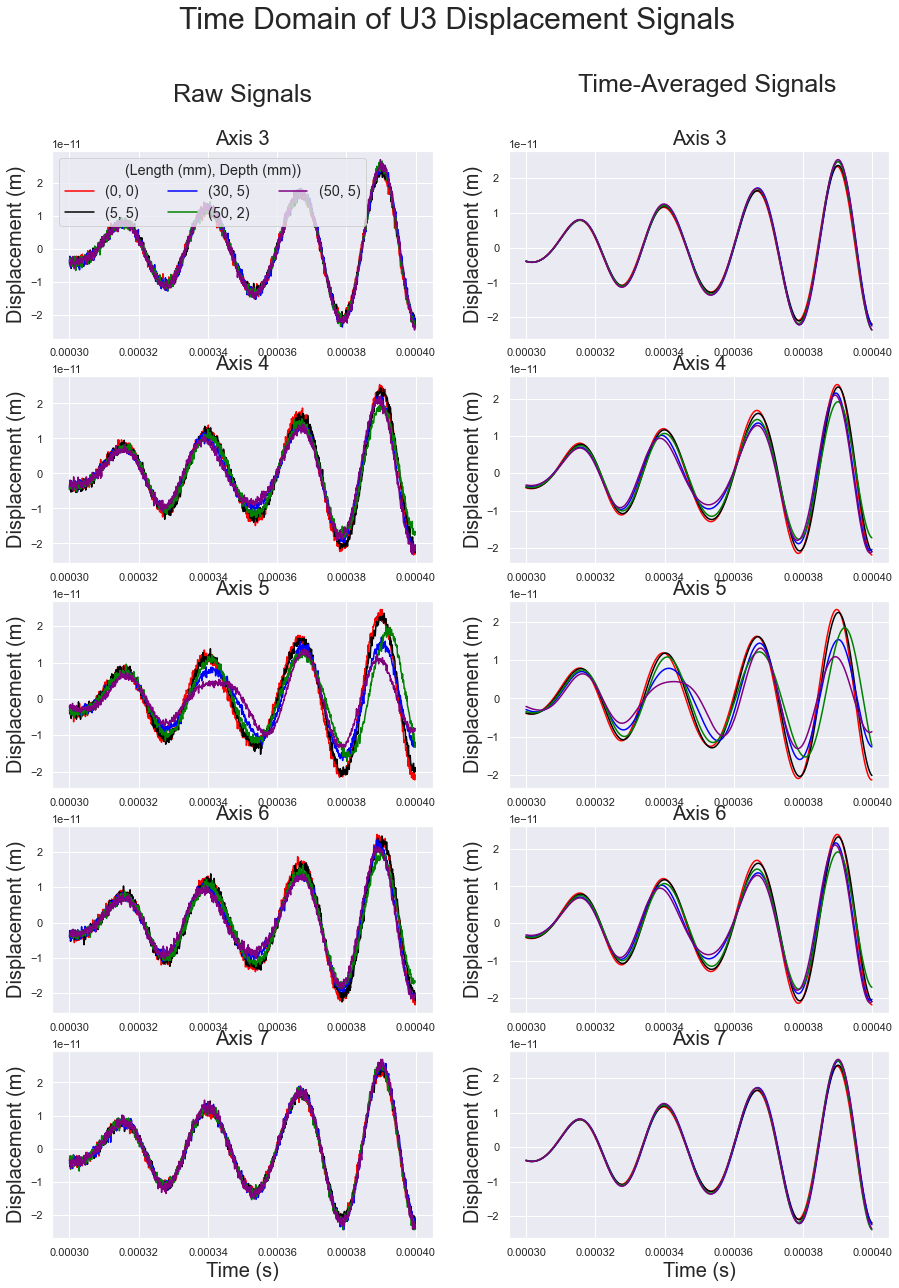

In [810]:
fig, ax = plt.subplots(len(axes), 2, figsize = (15,20))
i = 0
textyloc = 0;

for axis in axes:
    j = 0;
    subtitle = '';

    for state in states:

        is_state = (averaged_signals['Crack Properties',variables[0]] == state[0])&(averaged_signals['Crack Properties',variables[1]] == state[1]);
        is_axis  = averaged_signals['Transducer','Axis'] == axis;
        signal   = averaged_signals[is_state & is_axis];
        
        signal_time = signal['Time Domain (s)']
        
        if np.nan in signal_time:
            continue
            
        max_value = signal_time.to_numpy().max()
        
        this_state = variables[0] + ' = ' + str(state[0]) + ', ' + variables[1] + ' = ' + str(state[1])
        ax[i][0].plot(time,signal_time.to_numpy()[0], color = colors[j], label = this_state)
        ax[i][0].set_ylabel('Displacement (m)', fontsize = 20)
        ax[i][0].grid(visible = True, which = 'major')

        j = j + 1;
    
    i = i + 1
    
    ax[-1][0].set_xlabel('Time (s)', fontsize = 20)
    ax[-1][1].set_xlabel('Time (s)', fontsize = 20)
    
    textyloc = max(max_value*1.7,textyloc)
        
i = 0

for axis in axes:
    j = 0;
    subtitle = '';

    for state in states:

        is_state = (mode['Crack Properties',variables[0]] == state[0])&(mode['Crack Properties',variables[1]] == state[1]);
        is_axis  = mode['Transducer','Axis'] == axis;
        signal   = mode[is_state & is_axis];
        
        signal_time = signal['Time Domain (s)']
        
        if np.nan in signal_time:
            continue
            
        max_value = signal_time.to_numpy().max()
        
        this_state = variables[0] + ' = ' + str(state[0]) + ', ' + variables[1] + ' = ' + str(state[1])
        ax[i][1].plot(time,signal_time.to_numpy()[0], color = colors[j], label = this_state)
        ax[i][1].set_ylabel('Displacement (m)', fontsize = 20)
        ax[i][1].grid(visible = True, which = 'major')

        j = j + 1;
        
        subtitle = 'Axis ' + str(axis)
        ax[i][0].set_title(subtitle, fontsize = 20)
        ax[i][1].set_title(subtitle, fontsize = 20)
    
    i = i + 1
    
    ax[-1][0].set_xlabel('Time (s)', fontsize = 20)
    ax[-1][1].set_xlabel('Time (s)', fontsize = 20)
    
    textyloc = max(max_value*1.7,textyloc)
    
ax[0][0].text(0.00033, 0.9*textyloc, 'Raw Signals', fontsize = 25)
ax[0][1].text(0.000315, 0.9*textyloc, 'Time-Averaged Signals', fontsize = 25)

ax[0][0].legend(states, title = '(' + variables[0] + ', ' + variables[1] + ')', loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large', ncol = 3);

fig.suptitle('Time Domain of ' + StrainCoefficient + ' Displacement Signals', fontsize = 30)

fig.savefig('Time Domain',dpi = 250)

## Save analysis

Certain important data structures will be saved for further analysis. They will be saved as files only accessible by Python.

In [813]:
pickle.dump(mode, open('Mode 1, ' + StrainCoefficient + ' Signal Response','ab'))
pickle.dump(averaged_signals, open('Mode 1 Averaged, ' + StrainCoefficient + ' Signal Response','ab'))
pickle.dump(max_signals, open('Mode 1 Max, ' + StrainCoefficient + ' Signal Response','ab'))
pickle.dump(min_signals, open('Mode 1 Min, ' + StrainCoefficient + ' Signal Response','ab'))
pickle.dump(states, open('Damaged States','ab'))
pickle.dump(colors, open('Color Code','ab'))
pickle.dump(time, open('Time Axis','ab'))